# COURSE PROJECT: NEURAL NETWORKS FOR CLASSIFICATION

**SINH VIÊN 1**

Họ tên: Nguyễn Hoàng Khải Minh

MSSV: 22127267

<br>

**SINH VIÊN 2**

Họ tên: Lê Thị Ngọc Linh

MSSV: 22127232

<br>
(Cập nhật lần cuối: 23/11/2024)

## Import các thư viện cần thiết

In [1]:
import numpy as np
import os
import time
import pickle
import tarfile
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from track_memory import track_memory_use, plot_memory_use

## 1. Data preparation

Bộ dữ liệu được sử dụng trong đồ án này chính là CIFAR-10, gồm 60,000 hình ảnh 32x32 pixel, được chia thành 10 lớp:
<ul>
<li> Máy bay </li>
<li> Xe máy </li>
<li> Chim </li>
<li> Mèo </li>
<li> Hươu </li>
<li> Chó </li>
<li> Ếch </li>
<li> Ngựa </li>
<li> Tàu </li>
<li> Xe tải </li>
</ul>

Tập dữ liệu gồm 60,000 ảnh, được chia thành 50,000 ảnh cho tập huấn luyện và 10,000 ảnh dùng cho tập kiểm tra.

Hàm read_cifar() bên dưới đọc dữ liệu từ 5 batch trong tập dữ liệu train và lưu vào train_X, train_Y, sau đó đọc dữ liệu từ test batch và lưu vào test_X, test_Y, tổng cộng trả về 4 mảng train_X, train_Y, test_X, test_Y. Trong hàm đồng thời chuẩn hóa dữ liệu từ 0 - 255 (giá trị của 1 chanel tronng pixel) về đoạn 0 - 1.

In [2]:
def read_cifar():
    train_X = []
    train_Y = []

    for i in range (1, 6):
        with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
            train_data = pickle.load(f, encoding='bytes')
            train_X.append((train_data[b'data']) / 255.0)
            train_Y.append(train_data[b'labels'])
    train_X = np.concatenate(train_X, axis=0)
    train_Y = np.concatenate(train_Y)
    
    with open('cifar-10-batches-py/test_batch', 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
        test_X = np.array(test_data[b'data']) / 255.0
        test_Y = np.array(test_data[b'labels'])

    return train_X, train_Y, test_X, test_Y


train_X, train_Y, test_X, test_Y = read_cifar()

print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_Y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_Y.shape}')

Shape of train_X: (50000, 3072), shape of train_y: (50000,)
Shape of test_X:  (10000, 3072), shape of test_y:  (10000,)


In [3]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 1.0


Sau khi đọc sau, có thể xem qua một số ảnh trong bộ dữ liệu CIFAR-10.

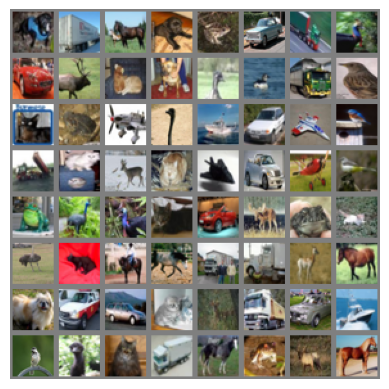

In [4]:
n_rimages = 8; n_cimages = 8 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (32 + 2 * padding), n_cimages * (32 + 2 * padding), 3))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(3, 32, 32).transpose(1, 2, 0)
        temp1 = r * (32 + 2 * padding) + padding 
        temp2 = c * (32 + 2 * padding) + padding 
        canvas[temp1:temp1 + 32, temp2:temp2 + 32, :] = image
plt.imshow(canvas, vmin=0, vmax=1)
plt.axis('off');

Tiếp theo, in ra các nhãn có trong tập huấn luyện và số lượng của mỗi nhãn. Có thể thấy cả 10 nhãn trong tập huấn luyện đều có số lượng bằng nhau là 5,000 hình cho mỗi nhãn, có thể thấy số lượng mỗi nhãn đều nhau.

In [5]:
def load_meta(meta_file):
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    return meta_data[b'label_names']

# Ví dụ:
meta_file = 'cifar-10-batches-py/batches.meta'
label_names = load_meta(meta_file)

values, counts = np.unique(train_Y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value} - {label_names[value].decode('utf-8')}, count: {count}')

Value: 0 - airplane, count: 5000
Value: 1 - automobile, count: 5000
Value: 2 - bird, count: 5000
Value: 3 - cat, count: 5000
Value: 4 - deer, count: 5000
Value: 5 - dog, count: 5000
Value: 6 - frog, count: 5000
Value: 7 - horse, count: 5000
Value: 8 - ship, count: 5000
Value: 9 - truck, count: 5000


Cuối cùng chính là hàm add_ones(), truyền vào ma trận X sau đó thêm cột 1 vào làm bias để hoàn thiện việc toàn xử lý. Ngoài ra có thêm hàm one_hot để encoding mảng output Y từ 0-9 về dạng one hot, để thuận tiện cho việc sử dụng các thư viện huấn luyện yêu cầu đầu vào của mảng Y phải là one hot như thư viện tensorflow.

In [6]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

def one_hot(Y):
    K = np.max(Y) + 1
    y_onehot = np.zeros((len(Y), K))
    y_onehot[np.arange(len(Y)), Y] = 1
    return y_onehot

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
print(f'Shape of train_Z: {train_Z.shape}')

# Gọi hàm one_hot để tiền xử lý train_Y
train_Y_onehot = one_hot(train_Y)
train_Y_onehot.shape
print(f'Shape of train_Y_onehot: {train_Y_onehot.shape}')


Shape of train_Z: (50000, 3073)
Shape of train_Y_onehot: (50000, 10)


## 2. Model Design

Mô hình này được thiết kế theo tham khảo từ bài viết "To Boost or not to Boost: On the Limits of Boosted" (link: https://www.researchgate.net/publication/353568132_To_Boost_or_not_to_Boost_On_the_Limits_of_Boosted_Neural_Networks)
<br><br>
Do trong báo cáo có sử dụng thuật toán MLP, và mô hình MLP được sử dụng trong báo cáo mang lại độ chính xác khá tốt so với mặt bằng chung (lớn hơn 60%) nên đó là cơ sở để nhóm em tham khảo từ nguồn này. Độ chính xác của mô hình được vẽ ở hình 10.a trang 25 của báo cáo, có thể thấy với số neurol ở hidden layers là (1002, 1002) thì độ chính xác lên gần đến 62%. Tuy nhiên (1002, 1002) thì chạy quá lâu nên quyết định cuối cùng sẽ là (512, 512).
<br><br>
Theo báo cáo, mô hình MLP phù hợp với optimizer SGD hơn là ADAM (đề cập ở phần Network Training Parameters trang 20, 21), tuy nhiên SGD phải có learning rate decay mới hiệu quả. Nhóm cũng đã thử qua 2 mô hình:

1. Adam - Learning rate init = 0.001
2. SGD - Learning rate init = 0.1 - learning rate decay: 0.1

Kết quả thu được chính là với cùng số epochs SGD sẽ mang lại Accuracy cao hơn vì một bước của SGD đi được xa hơn so với Adam. Do đó nhóm chọn optimizer sẽ là SGD kết hợp với learning rate decay.
<br><br>
Cuối cùng là các tham số khác như epochs và decay step. Mô hình ban đầu xài 300 epochs, lấy 95 epochs làm số step để giảm learning rate. Kết quả thu được thì 1 chu kỳ learning rate như vậy quá lớn, validation accuracy giảm liên tục trong 95 epochs rồi mới tăng đột ngột, tốt hơn ở learning rate mới. Do đó nhóm giảm xuống còn 100 epochs, 30 epochs cho mỗi step và sử dụng early stopping cho step cuối cùng (từ epoch 60).

![Validate accuracy with 300 epochs, 95 epochs per step, early stopping at last step](./img/val_300_epochs.jpg)
<br>
(Hình chụp lại trong quá trình test trước đó cho mô hình 300 epochs)

Cuối cùng, mô hình được chọn như sau

| Hyperparameter        | Value             |
|-----------------------|-------------------|
| Number of layers      | 2 hidden layers   |
| Neurons each layer    | 512, 512          |
| Activation function   | ReLU              |
| Optimizer             | SGD               |
| Weight decay          | 0.001             |
| Momentum              | 0                 |
| Learning rate init    | 0.1               |
| Learning rate decay   | 0.1               |
| Decay step            | 30 epochs         |
| Epochs                | 100               |
| Batch size            | 128               |
| Loss function         | Cross-entropy     |
| Validation fraction   | 0.1               |
| Early stopping        | True              |
| Stop from epoch       | 60                |

**SKLEARN**

In [7]:
@track_memory_use(close=False, return_history=True)
def mlp_sklearn(X, y, verbose=False):
    from sklearn.neural_network import MLPClassifier
    # Số epochs cho mỗi chu kỳ
    epochs_per_cycle = 30
    total_epochs = 100
    initial_lr = 0.1
    
    # Tính số chu kỳ
    num_cycles = total_epochs // epochs_per_cycle

    # Mô hình MLPClassifier
    model = MLPClassifier(
        hidden_layer_sizes=(512, 512),
        activation='relu',
        alpha=0.001,
        solver='sgd',
        momentum=0,
        learning_rate_init=initial_lr,
        batch_size=128,
        validation_fraction=0.1,
        max_iter=epochs_per_cycle,
        n_iter_no_change=epochs_per_cycle,
        early_stopping=True,
        tol=0,
        verbose=verbose,
        warm_start=True  # Giữ lại trạng thái mô hình khi huấn luyện thêm
    )

    # Huấn luyện mô hình với giảm learning rate sau mỗi chu kỳ
    for cycle in range(num_cycles):
        if (verbose):
            print(f"\n=== Cycle {cycle+1}/{num_cycles} ===")
        model.learning_rate_init = initial_lr * (10 ** -cycle)  # Giảm lr xuống 10 lần mỗi chu kỳ
        if (verbose):
            print(f"Learning rate: {model.learning_rate_init}")
        if cycle == num_cycles - 1:
            model.n_iter_no_change = 1
        model.fit(X, y)
    return model, {'train_loss': model.loss_curve_, 'val_loss': model.validation_scores_}


=== Cycle 1/3 ===
Learning rate: 0.1
Iteration 1, loss = 1.97381605
Validation score: 0.329400
Iteration 2, loss = 1.75406417
Validation score: 0.347200
Iteration 3, loss = 1.66357976
Validation score: 0.424600
Iteration 4, loss = 1.59807531
Validation score: 0.434600
Iteration 5, loss = 1.55345970
Validation score: 0.457800
Iteration 6, loss = 1.50385569
Validation score: 0.444200
Iteration 7, loss = 1.47051996
Validation score: 0.398600
Iteration 8, loss = 1.42773414
Validation score: 0.448800
Iteration 9, loss = 1.39647371
Validation score: 0.461200
Iteration 10, loss = 1.37144828
Validation score: 0.431200
Iteration 11, loss = 1.33741323
Validation score: 0.449600
Iteration 12, loss = 1.30851596
Validation score: 0.446200
Iteration 13, loss = 1.28320146
Validation score: 0.494200
Iteration 14, loss = 1.25257958
Validation score: 0.495000
Iteration 15, loss = 1.23088158
Validation score: 0.457200
Iteration 16, loss = 1.19985392
Validation score: 0.502400
Iteration 17, loss = 1.1785

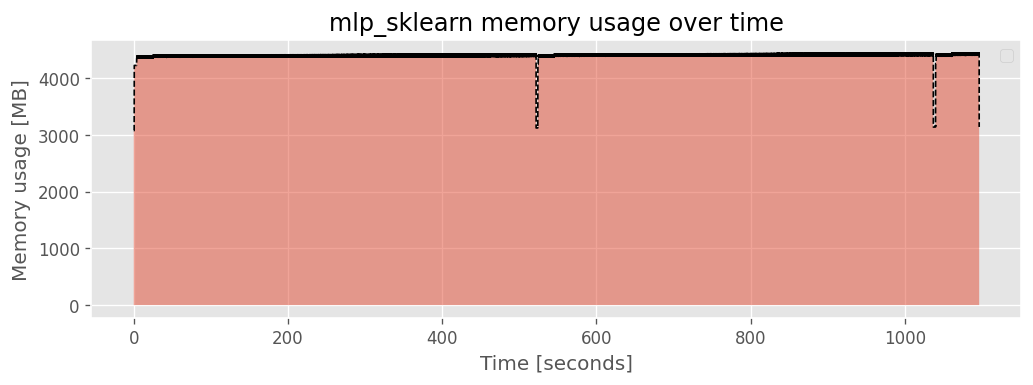

In [78]:
# Huấn luyện mô hình
(model_sklearn, histor_sklearn), mem_history_sklearn = mlp_sklearn(train_Z, train_Y, verbose=True)

In [80]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_sklearn.predict(test_Z)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

Accuracy: 55.79%
              precision    recall  f1-score   support

    airplane       0.62      0.64      0.63      1000
  automobile       0.67      0.66      0.66      1000
        bird       0.47      0.45      0.46      1000
         cat       0.38      0.39      0.39      1000
        deer       0.49      0.45      0.47      1000
         dog       0.46      0.44      0.45      1000
        frog       0.58      0.64      0.61      1000
       horse       0.64      0.62      0.63      1000
        ship       0.65      0.69      0.67      1000
       truck       0.59      0.60      0.60      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000

[[637  22  58  13  38  14  20  22 123  53]
 [ 31 658  17  24   8  18  13  18  64 149]
 [ 68  14 450  91 115  77  78  60  24  23]
 [ 26  18  83 387  54 192 116  59  24  41]
 [ 52  10 158  66 449  50 107  70  27  11]
 [ 21   8

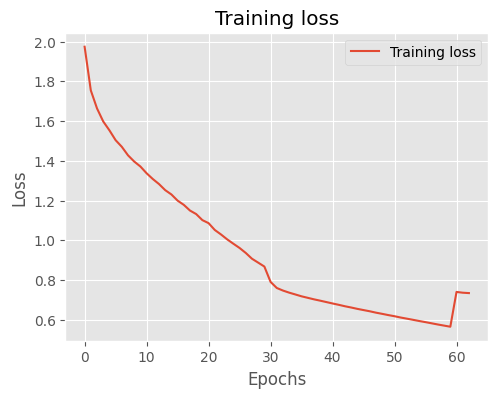

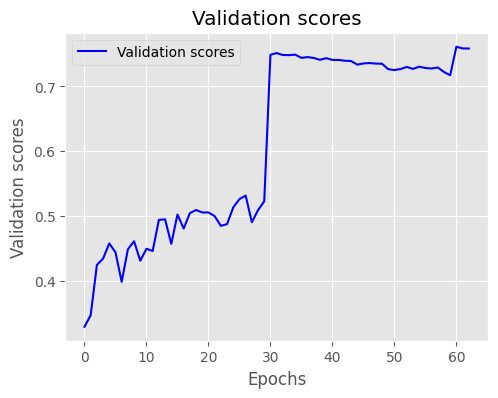

In [83]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_sklearn.loss_curve_, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_sklearn.validation_scores_, label='Validation scores', color='b')
plt.xlabel('Epochs')
plt.ylabel('Validation scores')
plt.title('Validation scores')
plt.legend()
plt.show()

**TENSORFLOW**

In [8]:
@track_memory_use(close=False, return_history=True)
def mlp_tf(X, y, verbose=False):
    import tensorflow as tf
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Input(shape=(X.shape[1], )),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=30*(X.shape[0]*0.9//128),
        decay_rate=0.1,
        staircase=True
    )

    sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule, weight_decay=0.001)

    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X, 
        one_hot(y), 
        epochs=100, 
        batch_size=128, 
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=0,
            min_delta=0,
            restore_best_weights=True,
            start_from_epoch=60
        )],
        verbose=verbose
    )
    return model, history

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2319 - loss: 2.1067 - val_accuracy: 0.3246 - val_loss: 1.8542
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3605 - loss: 1.7784 - val_accuracy: 0.3814 - val_loss: 1.7307
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3973 - loss: 1.6812 - val_accuracy: 0.3964 - val_loss: 1.6871
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4257 - loss: 1.6096 - val_accuracy: 0.4434 - val_loss: 1.5689
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4402 - loss: 1.5738 - val_accuracy: 0.4294 - val_loss: 1.5899
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4529 - loss: 1.5325 - val_accuracy: 0.4344 - val_loss: 1.5559
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4623 - loss: 1.5005 - val_accuracy: 0.4626 - val_loss: 1.4966
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4834 - loss: 1.4519 -

c:\Users\MSI BRAVO\source\repos\Nam 3\HK1\CSC14005_IntroduceML\CSC14005-Course-Project\track_memory.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


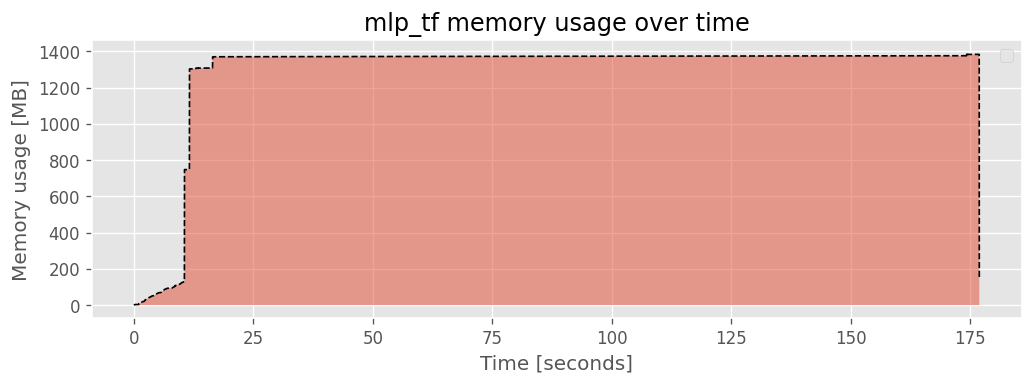

In [9]:
# Huấn luyện mô hình
(model_tf, history_tf), mem_history_tf = mlp_tf(train_Z, train_Y, verbose=True)

In [10]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_tf.predict(test_Z)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 56.81%
              precision    recall  f1-score   support

    airplane       0.63      0.66      0.64      1000
  automobile       0.69      0.68      0.69      1000
        bird       0.49      0.44      0.46      1000
         cat       0.39      0.40      0.39      1000
        deer       0.49      0.48      0.49      1000
         dog       0.47      0.44      0.45      1000
        frog       0.60      0.66      0.62      1000
       horse       0.62      0.64      0.63      1000
        ship       0.67      0.68      0.68      1000
       truck       0.60      0.62      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

[[655  27  47  22  38  13  22  25 103  48]
 [ 27 681  14  17   7  16  13  17  60 148]
 [ 73  15 443  91 125  71  82  59  18  23]
 [ 27  16  80 396  61 198 104  54  26  38]
 [ 51   5 1

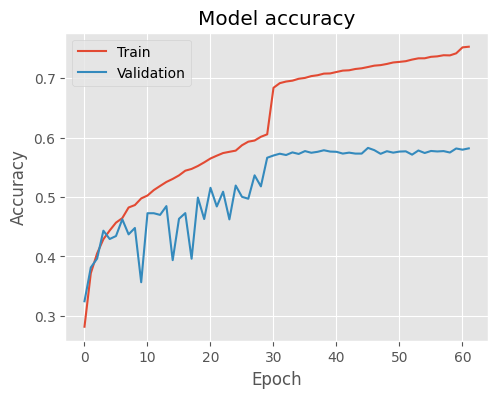

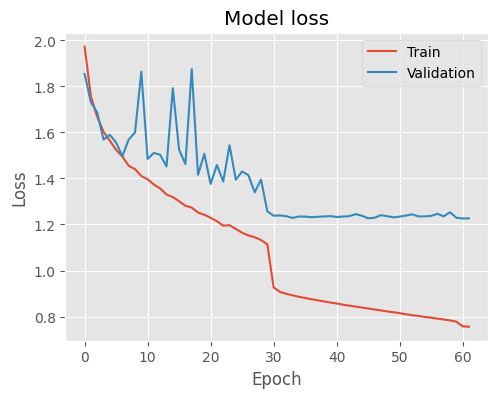

In [11]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tf.history['accuracy'], label='Train')
plt.plot(history_tf.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history_tf.history['loss'], label='Train')
plt.plot(history_tf.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**PYTORCH**

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self, input_size, ouput_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, ouput_size),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

@track_memory_use(close=False, return_history=True)
def mlp_pytorch(X, y, verbose=False):
    epochs = 100
    batch_size = 128
    patience = 0
    start_from_epoch = 60

    best_model = None

    # Convert data to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss, and optimizer
    input_size = X.shape[1]
    output_size = 10
    model = MLP(input_size, output_size)

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_accuracy": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        
        # Early stopping
        if epoch >= start_from_epoch:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        # Update learning rate
        lr_scheduler.step()
        if (verbose):
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
                f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)   
    
    return model, history


# Dự đoán
def pytorch_predict(model, test_X):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Tắt tính toán gradient
        # Thêm cột 1s (nếu cần)
        test_Z = torch.tensor(test_X, dtype=torch.float32)  # Convert test_X to PyTorch tensor
        
        # Dự đoán xác suất
        outputs = model(test_Z)
        
        # Lấy nhãn dự đoán (argmax trên xác suất)
        test_Y_pred = outputs.argmax(dim=1).numpy()  # Chuyển về numpy array
    return test_Y_pred 


Epoch 1/100, Train Loss: 2.0101, Val Loss: 1.9078, Val Accuracy: 0.2966, Learning Rate: 0.100000
Epoch 2/100, Train Loss: 1.7983, Val Loss: 1.8694, Val Accuracy: 0.3388, Learning Rate: 0.100000
Epoch 3/100, Train Loss: 1.7161, Val Loss: 1.7285, Val Accuracy: 0.3826, Learning Rate: 0.100000
Epoch 4/100, Train Loss: 1.6581, Val Loss: 1.6623, Val Accuracy: 0.4088, Learning Rate: 0.100000
Epoch 5/100, Train Loss: 1.6113, Val Loss: 1.6590, Val Accuracy: 0.4032, Learning Rate: 0.100000
Epoch 6/100, Train Loss: 1.5737, Val Loss: 1.5909, Val Accuracy: 0.4258, Learning Rate: 0.100000
Epoch 7/100, Train Loss: 1.5411, Val Loss: 1.6154, Val Accuracy: 0.4248, Learning Rate: 0.100000
Epoch 8/100, Train Loss: 1.5040, Val Loss: 1.5387, Val Accuracy: 0.4502, Learning Rate: 0.100000
Epoch 9/100, Train Loss: 1.4790, Val Loss: 1.6037, Val Accuracy: 0.4212, Learning Rate: 0.100000
Epoch 10/100, Train Loss: 1.4621, Val Loss: 1.6224, Val Accuracy: 0.4262, Learning Rate: 0.100000
Epoch 11/100, Train Loss: 1.4

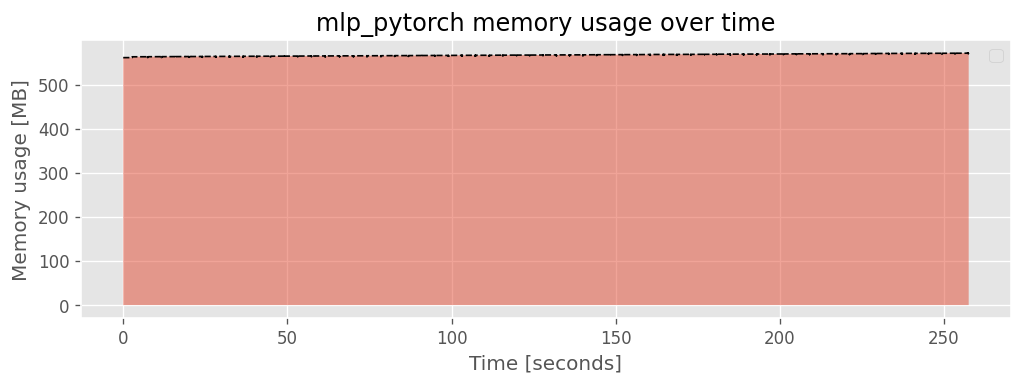

In [35]:
# Huấn luyện mô hình
(model_pytorch, hystory_pytorch), mem_history_pytorch = mlp_pytorch(train_Z, train_Y, verbose=True)

In [36]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = pytorch_predict(model_pytorch, test_Z)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)


Accuracy: 57.20%
              precision    recall  f1-score   support

    airplane       0.64      0.63      0.64      1000
  automobile       0.68      0.68      0.68      1000
        bird       0.49      0.46      0.48      1000
         cat       0.40      0.39      0.40      1000
        deer       0.49      0.49      0.49      1000
         dog       0.49      0.44      0.47      1000
        frog       0.58      0.67      0.62      1000
       horse       0.65      0.62      0.64      1000
        ship       0.67      0.70      0.68      1000
       truck       0.61      0.63      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

[[634  28  52  25  33  12  25  24 117  50]
 [ 30 677  14  17   8   7  16  16  66 149]
 [ 68  15 463  81 133  63  87  56  15  19]
 [ 25  13  73 393  62 182 127  52  31  42]
 [ 52   9 125  59 488  41 114  75  23  14]
 [ 19   5

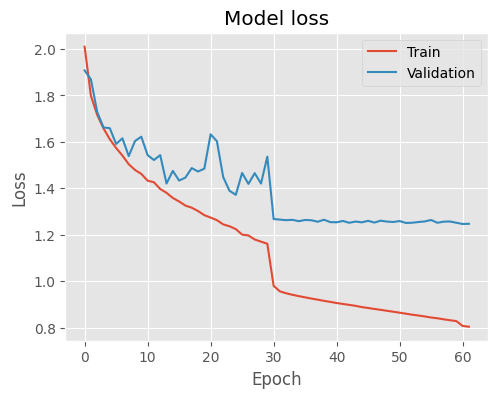

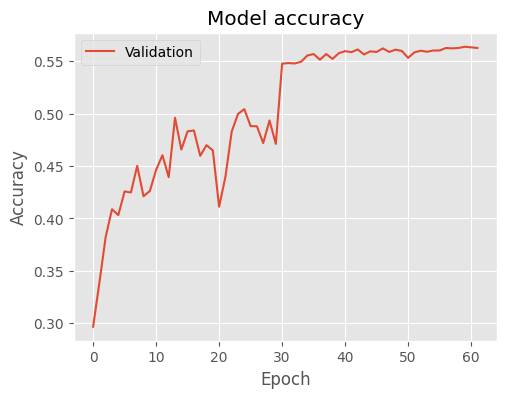

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hystory_pytorch['train_loss'], label='Train')
plt.plot(hystory_pytorch['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(hystory_pytorch['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## 3. Evaluation

Training with sklearn
Current memory usage: 610.223917
Peak memory usage: 1894.187071
Time: 23.29 minutes

Training with tf
Current memory usage: 694.253810
Peak memory usage: 1938.619281
Time: 5.55 minutes

Training with pytorch
Early stopping at epoch 62
Current memory usage: 684.123059
Peak memory usage: 685.936438
Time: 6.50 minutes



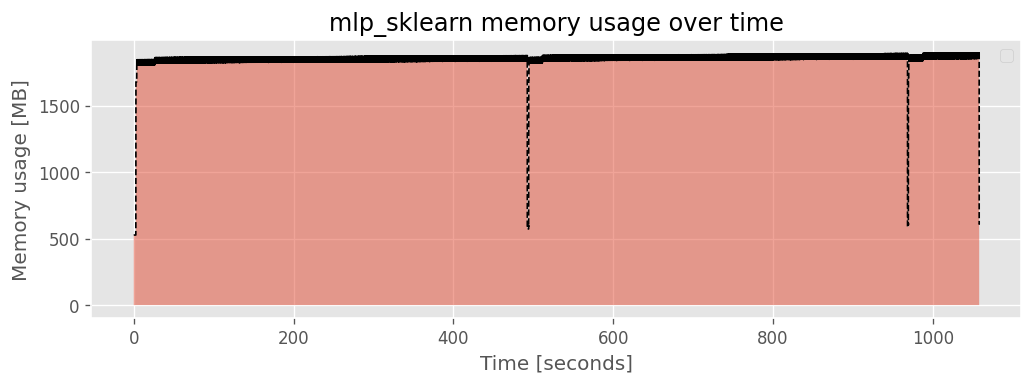

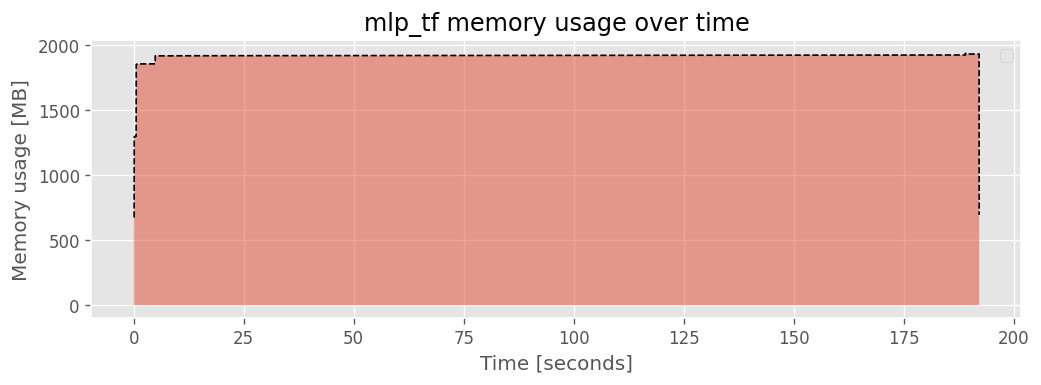

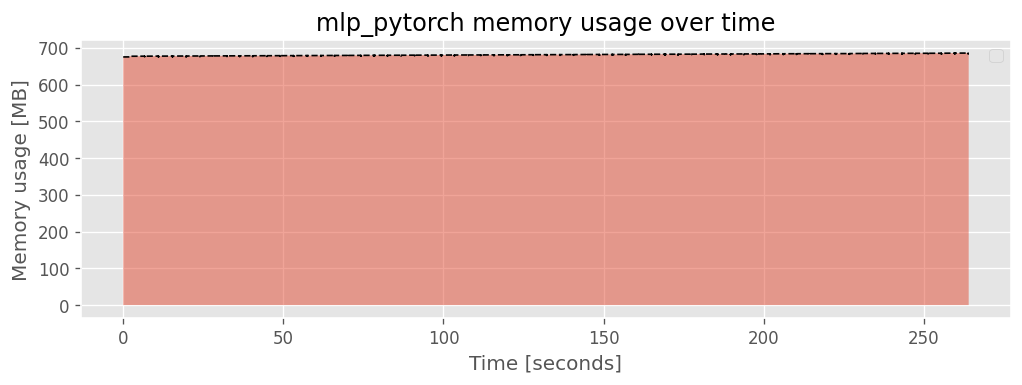

In [16]:
import torch
import time


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

train_function = {
    'sklearn': mlp_sklearn,
    'tf': mlp_tf,
    'pytorch': mlp_pytorch,
}

model = []
history = []
time_measure = []
memory_measure = []

for key, value in train_function.items():
    print(f"Training with {key}")
    start = time.time()

    # Huấn luyện model
    (model_, history_), mem_history_ = value(train_Z, train_Y)

    # Đo thời gian và GPU usage
    end = time.time()
    model.append(model_)
    history.append(history_)
    time_measure.append((end - start) / 60)
    memory_measure.append(max(mem_history_))

    print(f"Time: {(end - start) / 60:.2f} minutes")
    print()


In [17]:
test_Z = add_ones(test_X)

accuracy = []
model_confusion_matrix = []
model_classification_report = []

model_predict = {
    'sklearn': model[0].predict(test_Z),
    'tf': model[1].predict(test_Z),
    'pytorch': pytorch_predict(model[2], test_Z),
}


for key, predict_ in model_predict.items():
    if key == 'tf':
        predict_ = np.argmax(predict_, axis=1)
    accuracy_ = accuracy_score(test_Y, predict_)
    confusion_matrix_ = confusion_matrix(test_Y, predict_)
    classification_report_ = classification_report(test_Y, predict_, target_names=[label.decode('utf-8') for label in label_names])

    accuracy.append(accuracy_)
    model_confusion_matrix.append(confusion_matrix_)
    model_classification_report.append(classification_report_)

    print("====================================")
    print(f"Accuracy of {key}: {accuracy_ * 100:.2f}%")
    print(f"Confusion matrix of {key}:")
    print(confusion_matrix_)
    print(f"Classification report of {key}:")
    print(classification_report_)
    print()
    


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy of sklearn: 55.98%
Confusion matrix of sklearn:
[[623  27  49  15  37  16  26  23 132  52]
 [ 35 680  12  17   9  18  14  21  57 137]
 [ 70  11 430  88 133  76  92  54  23  23]
 [ 26  23  80 380  59 189 125  50  24  44]
 [ 47   6 130  66 469  48 120  68  32  14]
 [ 19   9  66 233  69 427  70  56  25  26]
 [ 12  15  62  73  97  45 651  16  10  19]
 [ 31  10  41  54  88  69  27 622  13  45]
 [ 91  53  13  25  24  14  10  12 706  52]
 [ 38 162   6  37  12  20  14  39  62 610]]
Classification report of sklearn:
              precision    recall  f1-score   support

    airplane       0.63      0.62      0.63      1000
  automobile       0.68      0.68      0.68      1000
        bird       0.48      0.43      0.46      1000
         cat       0.38      0.38      0.38      1000
        deer       0.47      0.47      0.47      1000
         dog       0.46      0.43      0.44      1000
        frog       0.57      0.65      0.61      1000
    

### Time measure

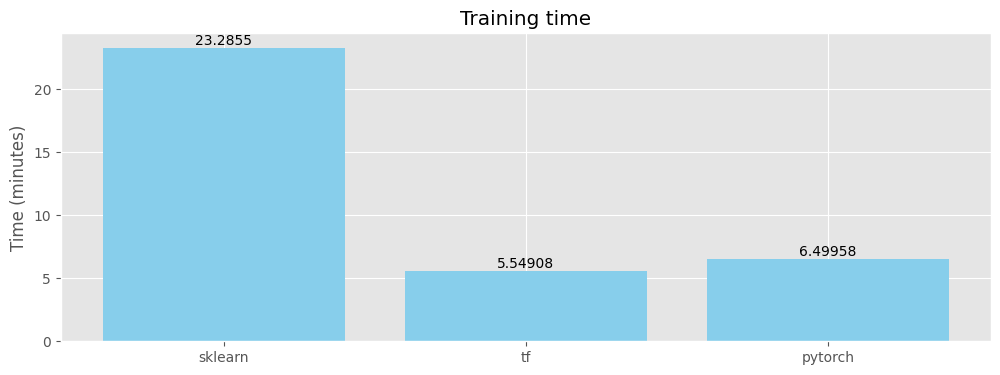

In [18]:
# Plot time of each library
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), time_measure, color='skyblue')
plt.bar_label(bars)
plt.ylabel('Time (minutes)')
plt.title('Training time')
plt.show()

### Memory usage

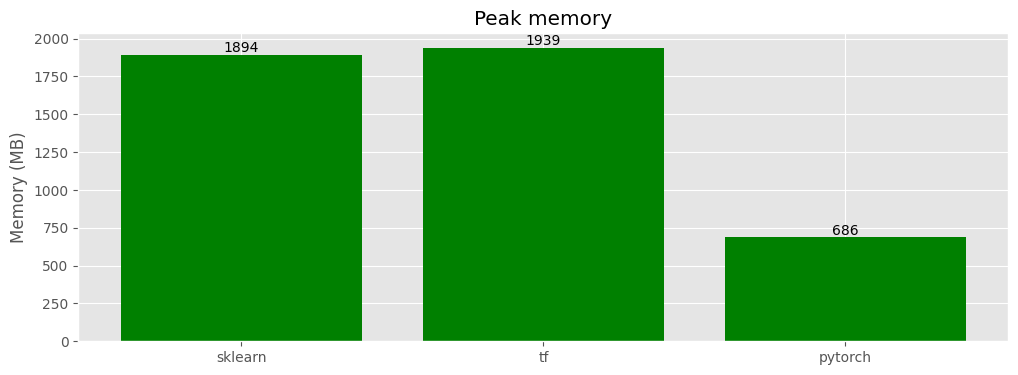

In [19]:
# Plot memory usage of each library
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), memory_measure, color='green')
plt.bar_label(bars, fmt='%.0f', label_type='edge')  
plt.ylabel('Memory (MB)')
plt.title('Peak memory')
plt.show()


### Accuracy

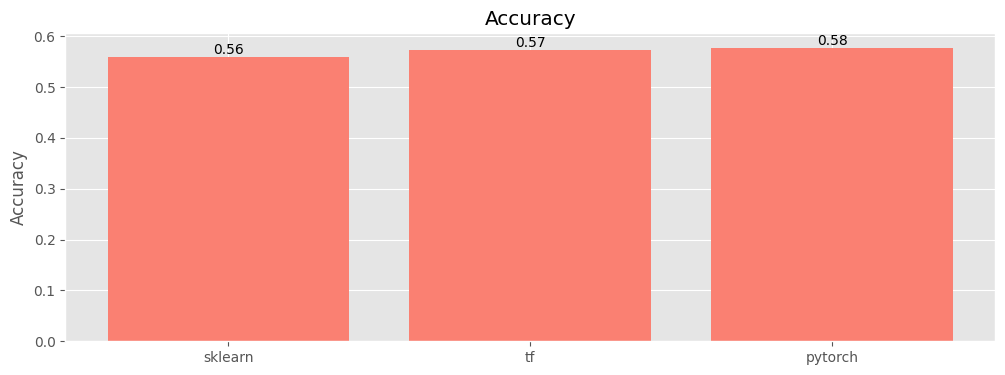

In [20]:
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), accuracy, color='salmon')
plt.bar_label(bars, fmt='%.2f', label_type='edge')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

### Training loss

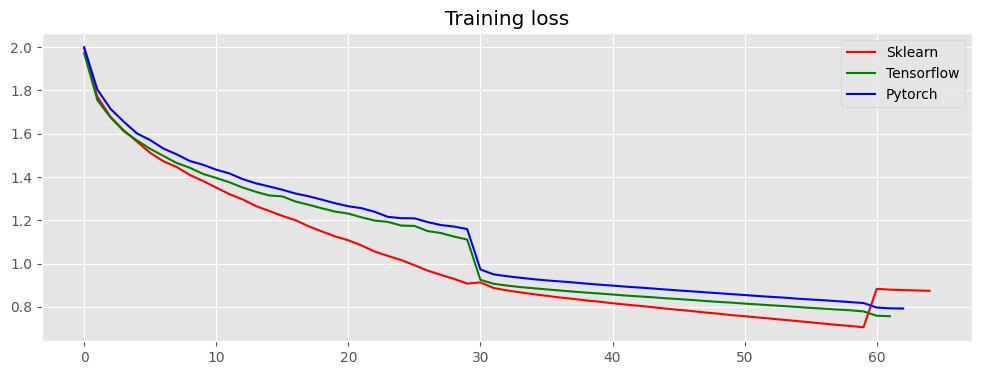

In [21]:

sklearn_loss = model[0].loss_curve_
tf_loss = history[1].history['loss']
pytorch_loss = history[2]['train_loss']

plt.figure(figsize=(12, 4))
plt.plot(sklearn_loss, label='Sklearn', color='r')
plt.plot(tf_loss, label='Tensorflow', color='g')
plt.plot(pytorch_loss, label='Pytorch', color='b')
plt.title('Training loss')
plt.legend()
plt.show()

### Validation scores

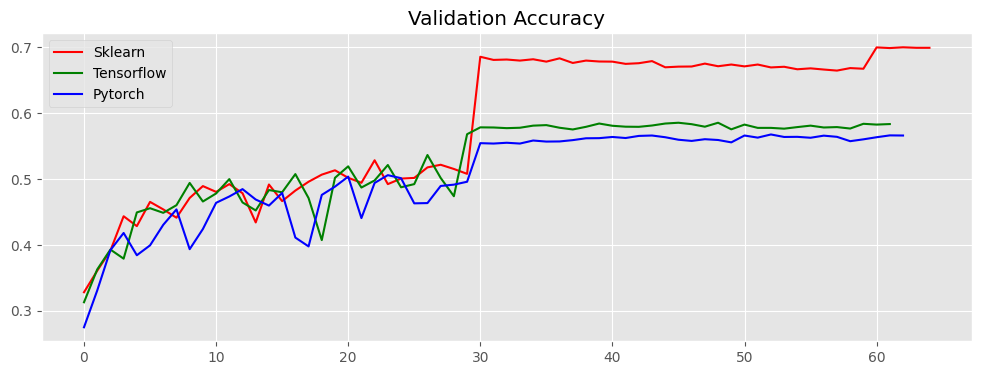

In [22]:
sk_learn_val_loss = model[0].validation_scores_
tf_val_loss = history[1].history['val_accuracy']
pytorch_val_loss = history[2]['val_accuracy']

plt.figure(figsize=(12, 4))
plt.plot(sk_learn_val_loss, label='Sklearn', color='r')
plt.plot(tf_val_loss, label='Tensorflow', color='g')
plt.plot(pytorch_val_loss, label='Pytorch', color='b')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


### Confusion matrix

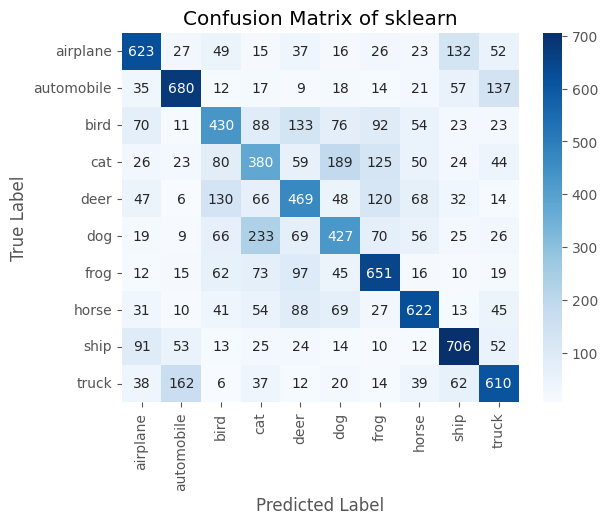

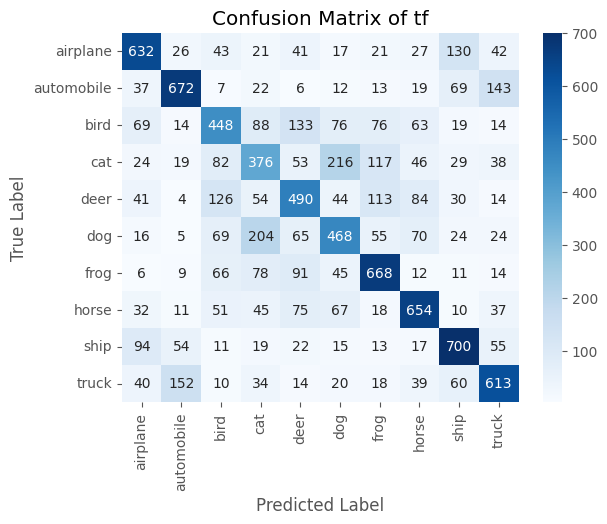

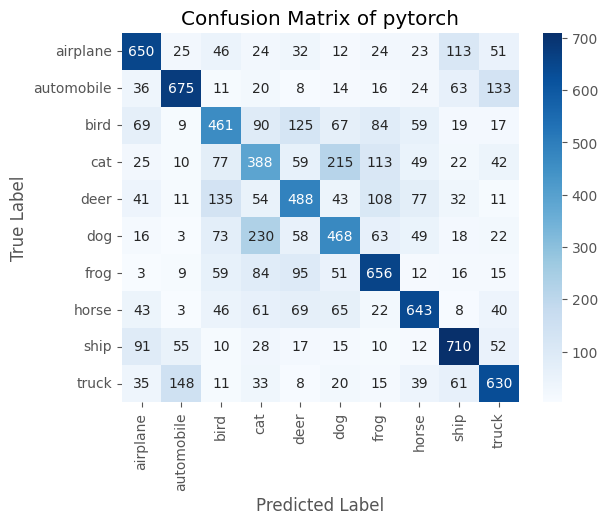

In [23]:
for key, cm in zip(train_function.keys(), model_confusion_matrix):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[name.decode('utf-8') for name in label_names],
        yticklabels=[name.decode('utf-8') for name in label_names]
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix of {key}')
    plt.show()

## 4. Save Model

In [38]:
from joblib import dump

# Lưu model vào file
dump(model[0], 'mlp_sklearn_model.joblib')
model[1].save('mlp_tensorflow_model.h5') 
torch.save(model[2].state_dict(), "mlp_pytorch_model.pth")

In [47]:
# test
from tensorflow.keras.models import load_model
from joblib import load

# Load model từ file
load_sklearn_model = load('mlp_sklearn_model.joblib')
load_tf_model = load_model('mlp_tensorflow_model.h5')
load_pytorch_model = MLP(train_Z.shape[1], len(np.unique(train_Y))).load_state_dict(torch.load("mlp_pytorch_model.pth"))
